In [1]:
import pymc as pm

parameter = pm.Exponential('poisson_param', 1)
data_generator = pm.Poisson('data_generator', parameter)
data_plus_one = data_generator + 1

D:\soft\dev\anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
print 'Children of parameter: '
print parameter.children
print '\nParents of data_generator: '
print data_generator.parents
print '\nChildren of data_generator: '
print data_generator.children

Children of parameter: 
set([<pymc.distributions.Poisson 'data_generator' at 0x000000000B672B38>])

Parents of data_generator: 
{'mu': <pymc.distributions.Exponential 'poisson_param' at 0x00000000033E03C8>}

Children of data_generator: 
set([<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x00000000033E0278>])


In [3]:
print 'parameter.value = ', parameter.value
print 'data_generator.value =', data_generator.value
print 'data_plus_one.value = ', data_plus_one.value

parameter.value =  0.601752783909
data_generator.value = 0
data_plus_one.value =  1


In [4]:
lambda_1 = pm.Exponential('lambda_1', 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print 'lambda_1.value = %.3f' % lambda_1.value
print 'lambda_2.value = %.3f' % lambda_2.value
print 'tau.value = %.3f' % tau.value
print

lambda_1.random(), lambda_2.random(), tau.random()

print 'After calling random() on the variables...'
print 'lambda_1.value = %.3f' % lambda_1.value
print 'lambda_2.value = %.3f' % lambda_2.value
print 'tau.value = %.3f' % tau.value

lambda_1.value = 1.847
lambda_2.value = 0.108
tau.value = 9.000

After calling random() on the variables...
lambda_1.value = 1.285
lambda_2.value = 0.567
tau.value = 7.000


In [5]:
import numpy as np
n_data_points= 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

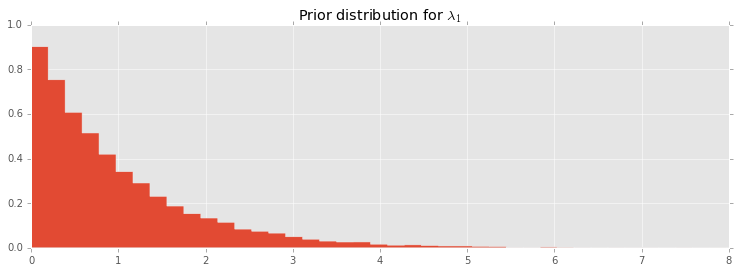

In [6]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
figsize(12.5, 4)

plt.style.use('ggplot')

samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, normed=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8);

In [7]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)
print 'value: ', fixed_variable.value
print 'calling .random()'
fixed_variable.random()
print 'value: ', fixed_variable.value

value:  [10  5]
calling .random()
value:  [10  5]


In [8]:
data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print obs.value

[10 25 15 20 35]


In [9]:
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])

### Same story; different ending.

In [10]:
tau = pm.rdiscrete_uniform(0, 80)
print tau

16


In [11]:
alpha = 1. / 20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print lambda_1, lambda_2

10.9128304138 5.78022080528


In [12]:
data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]

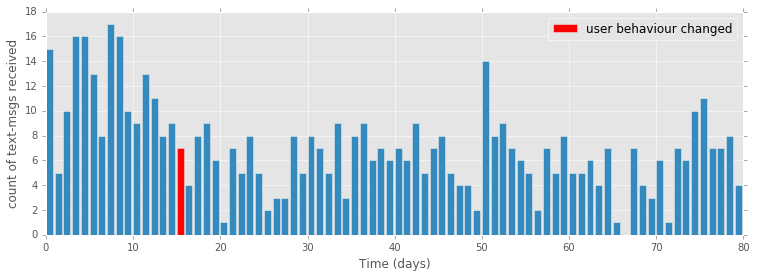

In [13]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau - 1, data[tau-1], color='r', label='user behaviour changed')
plt.xlabel('Time (days)')
plt.ylabel('count of text-msgs received')
plt.xlim(0, 80)
plt.legend()

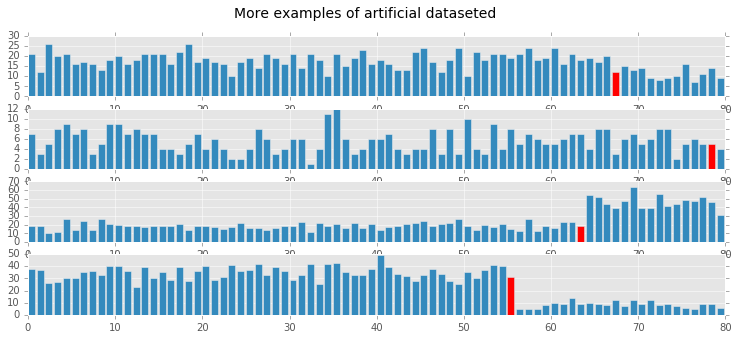

In [14]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_2, 80 - tau)]
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau - 1, data[tau - 1], color = 'r', label='user behaviour changed')
    plt.xlim(0, 80)
    
figsize(12.5, 5)
plt.suptitle('More examples of artificial dataseted', fontsize=14)
for i in range(1, 5):
    plt.subplot(4, 1, i)
    plot_artificial_sms_dataset()

### Example: Bayesian *A/B* testing

In [15]:
import pymc as pm

p = pm.Uniform('p', lower=0, upper=1)

In [16]:
p_true = 0.05
N = 1500

occurrences = pm.rbernoulli(p_true, N)

print occurrences
print occurrences.sum()

[False False False ..., False False False]
71


In [17]:
print 'What is the observed frequency in the Group A? %.4f' % occurrences.mean()
print 'Does this equal the true frequency? %s' % (occurrences.mean() == p_true)

What is the observed frequency in the Group A? 0.0473
Does this equal the true frequency? False


In [18]:
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

mcmc = pm.MCMC([p, obs])
mcmc.sample(18000, 1000)

 [-----------------100%-----------------] 18000 of 18000 complete in 0.8 sec

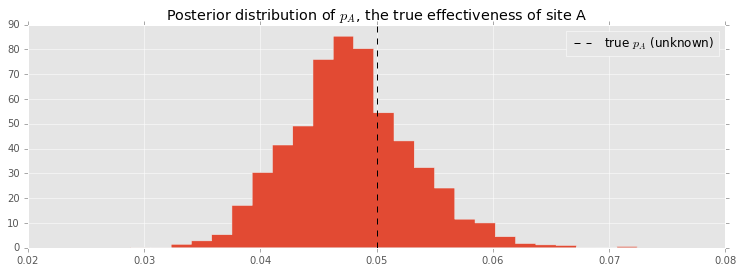

In [19]:
figsize(12.5, 4)
plt.title('Posterior distribution of $p_A$, the true effectiveness of site A')
plt.vlines(p_true, 0, 90, linestyle='--', label='true $p_A$ (unknown)')
plt.hist(mcmc.trace('p')[:], bins=25, histtype='stepfilled', normed=True)
plt.legend();

#### *A* and *B* together 

In [20]:
import pymc as pm
figsize(12, 4)

true_p_A = 0.05
true_p_B = 0.04

N_A = 1500
N_B = 750

observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print 'Obs from Site A: ', observations_A[:30].astype(int), '...'
print 'Obs from Site B: ', observations_B[:30].astype(int), '...'

Obs from Site A:  [0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] ...


In [21]:
print observations_A.mean()
print observations_B.mean()

0.052
0.044


In [22]:
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.5 sec

In [23]:
p_A_samples = mcmc.trace('p_A')[:]
p_B_samples = mcmc.trace('p_B')[:]
delta_samples = mcmc.trace('delta')[:]

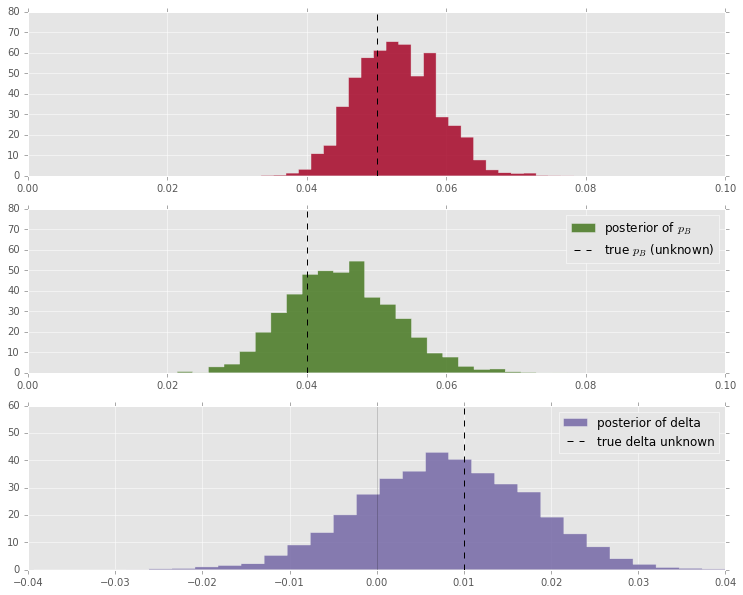

In [24]:
figsize(12.5, 10)

ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label='posterior of $p_A$', color='#A60628', normed=True)
plt.vlines(true_p_A, 0, 80, linestyle='--', label='true $p_A$ (unknown)')

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=25, alpha=0.85,
        label='posterior of $p_B$', color='#467821', normed=True)
plt.vlines(true_p_B, 0, 80, linestyle='--', label='true $p_B$ (unknown)')
plt.legend(loc='upper right')

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
        label='posterior of delta', color='#7468A6', normed=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle='--',
          label='true delta unknown')
plt.vlines(0, 0, 60, color='black', alpha=0.2)
plt.legend(loc='upper right');

In [25]:
print 'Probability site A is WORSE than site B: %.3f' % \
    (delta_samples < 0).mean()
print 'Probability site A is BETTER than site B %.3f' % \
    (delta_samples > 0).mean()

Probability site A is WORSE than site B: 0.203
Probability site A is BETTER than site B 0.797


#### Human deceint

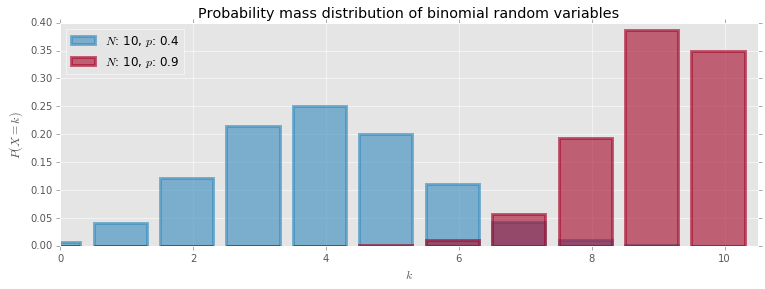

In [26]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60629']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i],
           edgecolor=colors[i],
           alpha=0.6,
           label='$N$: %d, $p$: %.1f' % (N, p),
           linewidth=3)
    
plt.legend(loc='upper left')
plt.xlim(0, 10.5)
plt.xlabel('$k$')
plt.ylabel('$P(X = k)$')
plt.title('Probability mass distribution of binomial random variables');

In [27]:
import pymc as pm

N = 100
p = pm.Uniform('freq_cheating', 0, 1)

In [28]:
true_answers = pm.Bernoulli('truths', p, size=N)

In [29]:
first_coin_flips = pm.Bernoulli('first_flips', 0.5, size=N)
print first_coin_flips.value

[ True  True  True False False False  True False False  True False  True
 False False  True  True  True  True False False  True  True False  True
 False  True False False  True False  True False False False  True  True
 False  True  True  True False False  True  True  True  True  True  True
  True  True  True  True False  True  True False  True  True  True False
  True  True False False  True  True  True  True False  True False  True
 False  True False  True False  True False False  True  True  True  True
 False  True False  True False False  True  True False False  True  True
  True  True  True False]


In [30]:
second_coin_flips = pm.Bernoulli('second_flips', 0.5, size=N)

In [31]:
@pm.deterministic
def observed_proportion(t_a=true_answers,
                       fc=first_coin_flips,
                       sc=second_coin_flips):
    observed = fc * t_a + (1 - fc) * sc
    return observed.sum() / float(N)

In [32]:
observed_proportion.value

0.65000000000000002

In [33]:
X = 35

observations = pm.Binomial('obs', N, observed_proportion, observed=True,
                          value=X)

In [34]:
model = pm.Model([p, true_answers, first_coin_flips,
                 second_coin_flips, observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 8.2 sec

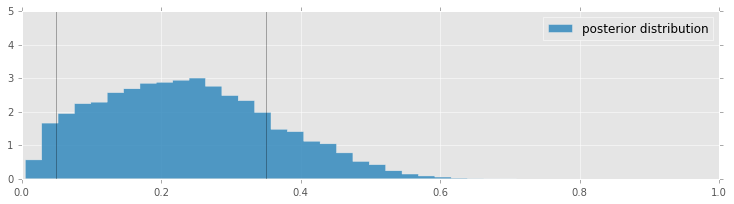

In [35]:
figsize(12.5, 3)
p_trace = mcmc.trace('freq_cheating')[:]
plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.85, bins=30,
        label='posterior distribution', color='#348ABD')
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.legend();

In [36]:
p = pm.Uniform('freq_cheating', 0, 1)

@pm.deterministic
def p_skewed(p=p):
    return 0.5 * p + 0.25

In [37]:
yes_responses = pm.Binomial('number_cheaters', 100, p_skewed,
                           value=35, observed=True)

In [38]:
model = pm.Model([yes_responses, p_skewed, p])

mcmc = pm.MCMC(model)
mcmc.sample(25000, 2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 0.9 sec

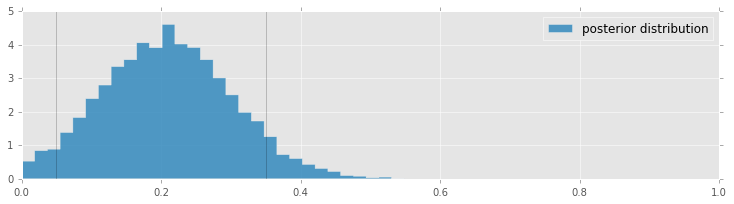

In [39]:
figsize(12.5, 3)
p_trace = mcmc.trace('freq_cheating')[:]
plt.hist(p_trace, histtype='stepfilled', normed=True, alpha=0.85, bins=30,
        label='posterior distribution', color='#348ABD')
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.legend();

In [40]:
N = 10
x = np.empty(N, dtype=object)
for i in range(0, N):
    x[i] = pm.Exponential('x_%i' % i, (i + 1) ** 2)

### Challenger Space Shuttle Disaster

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


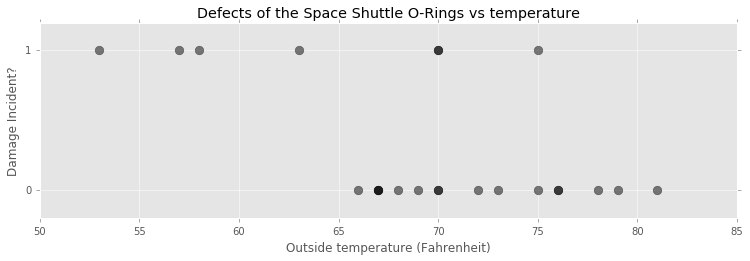

In [41]:
figsize(12.5, 3.5)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('./data/challenger_data.csv', skip_header=1,
                               usecols=[1, 2], missing_values='NA',
                               delimiter=',')

challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

print 'Temp (F), O-Ring failure?'
print challenger_data

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color='k',
           alpha=0.5)

plt.yticks([0, 1])
plt.ylabel('Damage Incident?')
plt.xlabel('Outside temperature (Fahrenheit)')
plt.title('Defects of the Space Shuttle O-Rings vs temperature')

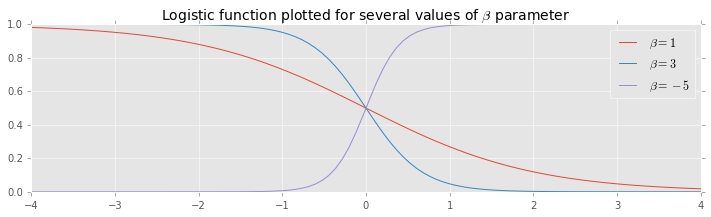

In [42]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r'$\beta = 1$')
plt.plot(x, logistic(x, 3), label=r'$\beta = 3$')
plt.plot(x, logistic(x, -5), label=r'$\beta = -5$')
plt.title('Logistic function plotted for several values of $\\beta$ parameter',
         fontsize=14)
plt.legend();

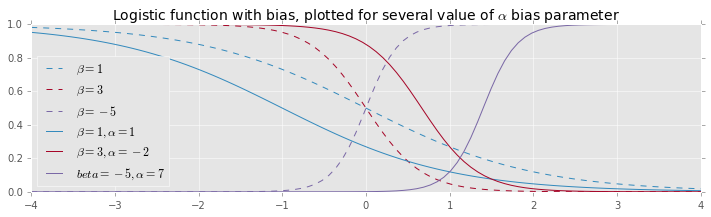

In [43]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r'$\beta = 1$', ls='--', lw=1, color='#348ABD')
plt.plot(x, logistic(x, 3), label=r'$\beta = 3$', ls='--', lw=1, color='#A60628')
plt.plot(x, logistic(x, -5), label=r'$\beta = -5$', ls='--', lw=1, color='#7A68A6')

plt.plot(x, logistic(x, 1, 1), label=r'$\beta = 1, \alpha = 1$',
        color='#348ABD')
plt.plot(x, logistic(x, 3, -2), label=r'$\beta = 3, \alpha = -2$',
        color='#A60628')
plt.plot(x, logistic(x, -5, 7), label=r'$beta = -5, \alpha = 7$',
        color='#7A68A6')

plt.title('Logistic function with bias, plotted for several value of $\\alpha$ bias parameter',
         fontsize=14)
plt.legend(loc='lower left');

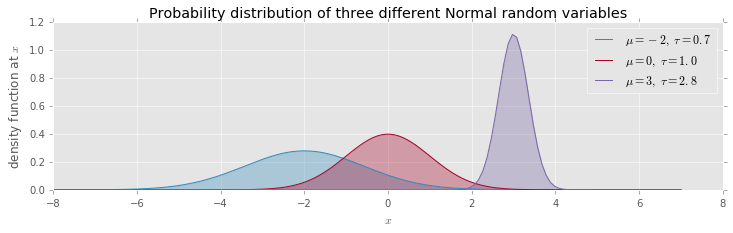

In [44]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ['#348ABD', '#A60628', '#7A68A6']
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1./_tau),
            label='$\mu = %d,\;\\tau = %.1f$' % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1./_tau), color=_color,
                    alpha=.33)
    
plt.legend(loc='upper right')
plt.xlabel('$x$')
plt.ylabel('density function at $x$')
plt.title('Probability distribution of three different Normal random \
variables');

In [45]:
import pymc as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]

beta = pm.Normal('beta', 0, 0.001, value=0)
alpha = pm.Normal('alpha', 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1. + np.exp(beta * t + alpha))

In [46]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [47]:
observed = pm.Bernoulli('bernoulli_obs', p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

 [-----------------100%-----------------] 120000 of 120000 complete in 6.6 sec

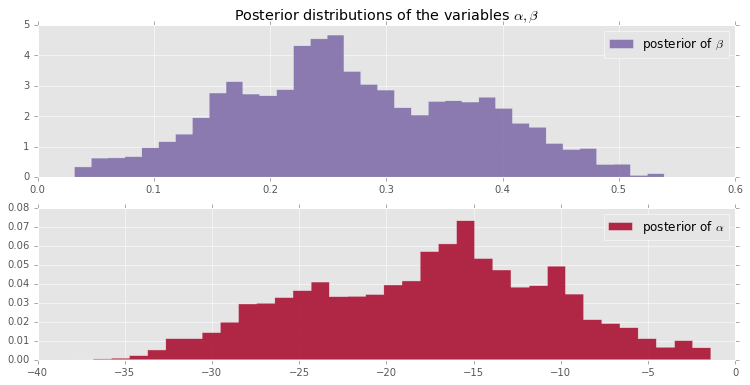

In [48]:
alpha_samples = mcmc.trace('alpha')[:, None]
beta_samples= mcmc.trace('beta')[:, None]

figsize(12.5, 6)

plt.subplot(211)
plt.title(r'Posterior distributions of the variables $\alpha, \beta$')
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
        label=r'posterior of $\beta$', color='#7A68A6', normed=True)
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
        label=r'posterior of $\alpha$', color='#A60628', normed=True)
plt.legend();

In [49]:
t = np.linspace(temperature.min() - 5, temperature.max() + 5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)

mean_prob_t = p_t.mean(axis=0)

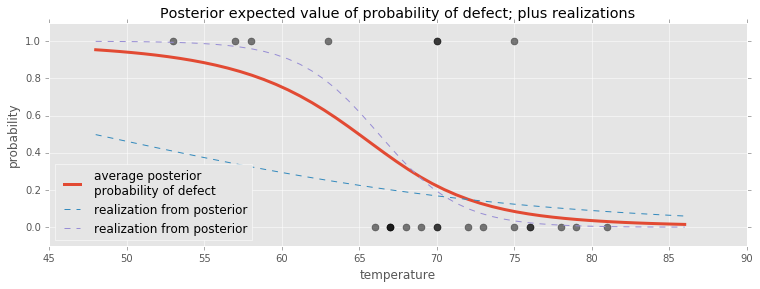

In [50]:
figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label='average posterior \nprobability \
of defect')
plt.plot(t, p_t[0, :], ls='--', label='realization from posterior')
plt.plot(t, p_t[-2, :], ls='--', label='realization from posterior')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.title('Posterior expected value of probability of defect; \
plus realizations')
plt.legend(loc='lower left')
plt.ylim(-0.1, 1.1)
plt.ylabel('probability')
plt.xlabel('temperature');

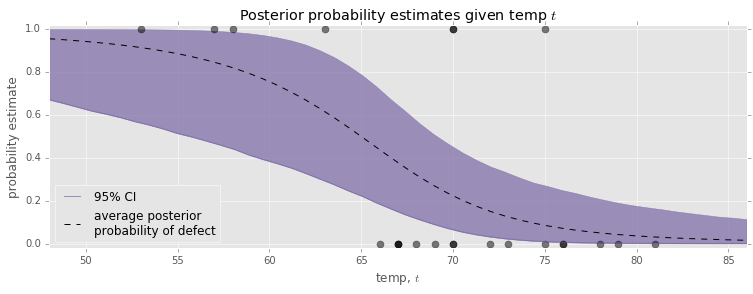

In [51]:
from scipy.stats.mstats import mquantiles

qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], *qs, alpha=0.7, color='#7A68A6')

plt.plot(t[:, 0], qs[0], label='95% CI', color='#7A68A6', alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls='--', color='k',
        label='average posterior \nprobability of defect')

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower left')
plt.scatter(temperature, D, color='k', s=50, alpha=0.5)
plt.xlabel('temp, $t$')

plt.ylabel('probability estimate')
plt.title('Posterior probability estimates given temp $t$')

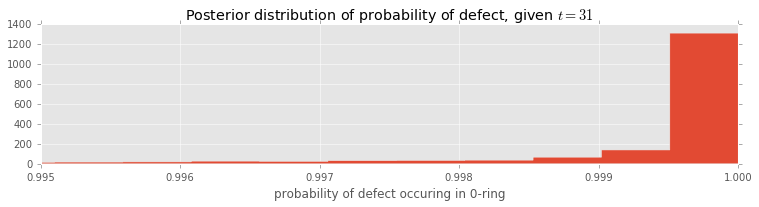

In [52]:
figsize(12.5, 2.5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, normed=True, histtype='stepfilled')
plt.title('Posterior distribution of probability of defect, given $t = 31$')
plt.xlabel('probability of defect occuring in 0-ring');

In [59]:
simulated = pm.Bernoulli('bernoulli_sim', p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.2 sec

(10000L, 23L)


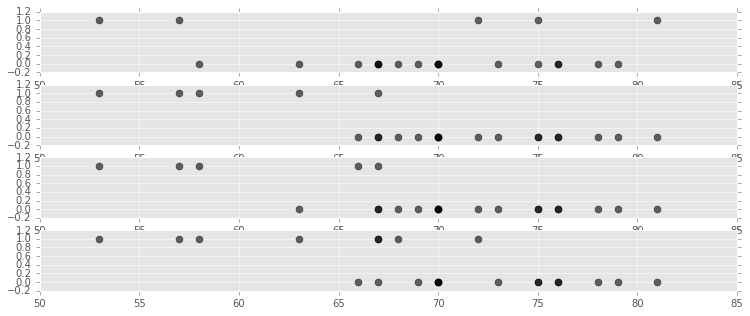

In [60]:
figsize(12.5, 5)

simulations = mcmc.trace('bernoulli_sim')[:]
print simulations.shape

plt.title('Simulated datased using posterior parameters')
figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
    plt.scatter(temperature, simulations[1000 * i, :], color='k',
               s=50, alpha=0.6)

In [62]:
posterior_probabiliy = simulations.mean(axis=0)
print 'posterior prob of defect | realized defect'
for i in range(len(D)):
    print '%.2f   | %d' % (posterior_probabiliy[i], D[i])

posterior prob of defect | realized defect
0.39   | 0
0.15   | 1
0.19   | 0
0.24   | 0
0.32   | 0
0.08   | 0
0.06   | 0
0.14   | 0
0.93   | 1
0.65   | 1
0.14   | 1
0.01   | 0
0.32   | 0
0.98   | 1
0.33   | 0
0.03   | 0
0.15   | 0
0.00   | 0
0.02   | 0
0.01   | 0
0.03   | 1
0.02   | 0
0.91   | 1


In [64]:
ix = np.argsort(posterior_probabiliy)
print 'probb | defect'
for i in range(len(D)):
    print '%.2f    | %d' % (posterior_probabiliy[ix[i]], D[ix[i]])

probb | defect
0.00    | 0
0.01    | 0
0.01    | 0
0.02    | 0
0.02    | 0
0.03    | 0
0.03    | 1
0.06    | 0
0.08    | 0
0.14    | 1
0.14    | 0
0.15    | 1
0.15    | 0
0.19    | 0
0.24    | 0
0.32    | 0
0.32    | 0
0.33    | 0
0.39    | 0
0.65    | 1
0.91    | 1
0.93    | 1
0.98    | 1
